In [1]:
import torch
#from data import *
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from torch.optim import Adagrad
from torch.optim import Adam
from tqdm import tqdm
#from vae import *
#import argparse

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec


In [2]:
HIDDEN=64
BATCH_SIZE=32
EPOCHS=50
LR=2e-3
LATENT=64


#specify the device
device="cuda:0"

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim=2):
        """
            @param input_dim: input dimension of the data
            @param hidden_dim: hidden dimension of the MLPs
            @param latent_dim: output dimension of MLPs
            @------------------@
            @return: None
        """
        super(VAE,self).__init__()
        self.en = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim,latent_dim)
        
        self.de = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )

        self.final_layer=nn.Sequential(
            nn.Linear(hidden_dim,input_dim),
        )

        
          
    def encode(self,x):
        #x = torch.flatten(x)
        res = self.en(x)
        mu = self.mu(res)
        log_var = self.var(res)
        
        return mu,log_var
            
    def decode(self,x):
        res = self.de(x)
        res = self.final_layer(res)
        return res
    def reparameterize(self,mu,log_var):
        epsilon = torch.normal(mu,torch.exp(0.5 * log_var))
        return mu + log_var * epsilon
    def forward(self,x):
        mu, log_var = self.encode(x)
        norm = self.reparameterize(mu,log_var)
        res = self.decode(norm)
        return (res, x, mu,log_var)



    def loss_fc(self,x,label,*args):
        (res, x, mu, log_var) = self.forward(x)
        recon_loss = F.mse_loss(res,label)
        KL_divergence = torch.mean(-0.5 * torch.sum((1 + log_var - mu**2 - torch.exp(log_var)),dim=1), dim=0)
        KL_divergence.required_grad = True
        loss = recon_loss + KL_divergence
        
        return dict({'loss': loss, 'recon_loss': recon_loss, 'kl_loss': KL_divergence})



    def generate(self,x):
        return self.forward(x)[0]


In [4]:
from scipy.io import loadmat

def get_minibatch(x,batch_size,device='cpu'):
    indices = torch.randperm(x.shape[0])[:batch_size]
    return x[indices].reshape(batch_size, -1).to(device)

# This is get_data fc for MNIST handwritten, below is for MNIST Fashion
"""
def get_data(path,nums=25000,device='cpu'):
    img_data = scipy.io.loadmat(path)["data"].T / 255.
    img_data = torch.Tensor(img_data)
    img_data = get_minibatch(img_data,nums)
    img_data = img_data.to(device)
    distri = torch.zeros(img_data.shape)
    
    print(f"Shape of a data point: {img_data.shape}")
    print(f"Example data {img_data[0:1].shape}")
    break_point = int(0.8*nums)
    return img_data[:break_point], img_data[:break_point]
"""
def get_data(path, nums=25000, device='cpu'):
    data = np.genfromtxt(path, delimiter=',')
    data = data[1:,1:] / 255.0
    data = torch.Tensor(data).to(device)
    data = get_minibatch(data,nums)
    return data

def add_noise(data, std=1/10.,device='cpu'):
    distri = torch.normal(torch.zeros(data.shape),torch.ones(data.shape) * std).to(device)
    #print(data.device)
    return data.to(device) + distri
    #print(distri)

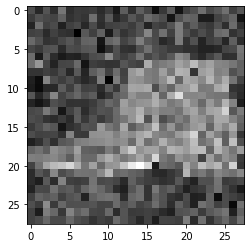

In [5]:
x = get_data("../Data/fashion.csv", nums=60000)


eval_data = get_data("../Data/fashion_eval.csv", nums=10000).to(device)
eval_data_full = (eval_data, add_noise(eval_data,std=1/4.,device=device))


t = add_noise(x,std=1/4.,device=device).cpu().detach().numpy()
plt.imshow(t[0].reshape(28,28),cmap="gray")

In [6]:
for k in eval_data_full: print(k.device)

cuda:0
cuda:0


In [23]:
def AEVB(data, eval_data, model, optimizer, input_dim, output_dim,epochs, batch_size):
    full_loss, kld, recon = [],[],[]
    efull_loss, ekld, erecon = [],[],[]
    for epc in range(epochs):
        fl,kl,rec = 0,0,0
        efl,ekl,erec = 0,0,0
        steps = x.shape[0] // batch_size
        for _ in tqdm(range(steps)):
            batch = get_minibatch(x,batch_size,device)
            batch_noise = add_noise(batch, std=1/45., device=device)
            optimizer.zero_grad()
 
            losses = model.loss_fc(batch_noise,batch)
            
            fl += losses["loss"].item() / batch_size
            kl += losses["kl_loss"].item() / batch_size
            rec += losses["recon_loss"].item() / batch_size
            losses["loss"].backward()
            optimizer.step()
            #for k in eval_data_full: print(k.device)
            elosses = model.loss_fc(eval_data_full[1],eval_data_full[0])  
            efl += elosses["loss"].item() / batch_size
            ekl += elosses["kl_loss"].item() / batch_size
            erec += elosses["recon_loss"].item() / batch_size
        #fl/= steps; kl /= steps; rec /= steps
        full_loss.append(fl); kld.append(kl); recon.append(rec)
        efull_loss.append(efl); ekld.append(ekl); erecon.append(erec)
        print(f"Epoch {epc + 1}\tFull loss: {full_loss[-1]}\trecon loss: {recon[-1]}\tkl_divergence: {kld[-1]}")
        
    return model, (full_loss, kld, recon),(efull_loss, ekld, erecon)





In [8]:
#Model 
model = VAE(x.shape[1],HIDDEN,LATENT).to(device)
# Optimizer

optimizer = Adam(model.parameters(), lr=LR)

In [9]:
(model, train_loss, eval_loss) = AEVB(data=x,
                                      eval_data=eval_data_full,
                                      model=model,
                                      optimizer=optimizer,
                                      input_dim=x.shape[1],
                                      output_dim=x.shape[1],
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.89it/s]


Epoch 1	Full loss: 5.2405939468881115	recon loss: 2.9288618995342404	kl_divergence: 2.6721951315703336


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 102.54it/s]


Epoch 2	Full loss: 2.2289866583887488	recon loss: 1.876786369481124	kl_divergence: 0.45171312664751895


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 102.10it/s]


Epoch 3	Full loss: 1.7851433922769502	recon loss: 1.576389424619265	kl_divergence: 0.21977043227525428


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 103.45it/s]


Epoch 4	Full loss: 1.5125012105563655	recon loss: 1.3677298710099421	kl_divergence: 0.11625962061225437


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 98.59it/s]


Epoch 5	Full loss: 1.3004963552230038	recon loss: 1.2092448661569506	kl_divergence: 0.05635549244470894


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 101.00it/s]


Epoch 6	Full loss: 1.1708163237490226	recon loss: 1.1127797737717628	kl_divergence: 0.03408772236434743


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 98.39it/s]


Epoch 7	Full loss: 1.0989272988808807	recon loss: 1.062177030777093	kl_divergence: 0.028123908763518557


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.85it/s]


Epoch 8	Full loss: 1.0565790854743682	recon loss: 1.0347839366295375	kl_divergence: 0.02706710423808545


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.77it/s]


Epoch 9	Full loss: 1.018870037427405	recon loss: 1.017221211688593	kl_divergence: 0.026014275004854426


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.90it/s]


Epoch 10	Full loss: 0.9941044266452082	recon loss: 1.0030301601509564	kl_divergence: 0.02495935492333956


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.27it/s]


Epoch 11	Full loss: 0.977430129511049	recon loss: 0.9952797536388971	kl_divergence: 0.025206023652572185


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 98.61it/s]


Epoch 12	Full loss: 0.9553270129254088	recon loss: 0.9830785625381395	kl_divergence: 0.023916660400573164


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.07it/s]


Epoch 13	Full loss: 0.9458803601155523	recon loss: 0.9783241818659008	kl_divergence: 0.023743263707729056


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.56it/s]


Epoch 14	Full loss: 0.9380845025007147	recon loss: 0.9796667044283822	kl_divergence: 0.02372273919172585


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 98.71it/s]


Epoch 15	Full loss: 0.9322484318981878	recon loss: 0.9772432454046793	kl_divergence: 0.023499042814364657


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.84it/s]


Epoch 16	Full loss: 0.9219496063305996	recon loss: 0.9761171659920365	kl_divergence: 0.02303131649387069


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.21it/s]


Epoch 17	Full loss: 0.918066366109997	recon loss: 0.9694021660252474	kl_divergence: 0.023015541664790362


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 98.48it/s]


Epoch 18	Full loss: 0.9133424584579188	recon loss: 0.9663934729760513	kl_divergence: 0.022974286024691537


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.51it/s]


Epoch 19	Full loss: 0.9161517044703942	recon loss: 0.9641775416675955	kl_divergence: 0.022417883039452136


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.80it/s]


Epoch 20	Full loss: 0.913904454180738	recon loss: 0.962437754322309	kl_divergence: 0.022730336640961468


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 98.38it/s]


Epoch 21	Full loss: 0.9082888666598592	recon loss: 0.9584232074557804	kl_divergence: 0.02296900615328923


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.25it/s]


Epoch 22	Full loss: 0.9054562549863476	recon loss: 0.9591585221933201	kl_divergence: 0.022625760320806876


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.16it/s]


Epoch 23	Full loss: 0.9045903136720881	recon loss: 0.9614014725666493	kl_divergence: 0.022560407785931602


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.99it/s]


Epoch 24	Full loss: 0.8911050345923286	recon loss: 0.9538819576846436	kl_divergence: 0.02162486733868718


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 96.82it/s]


Epoch 25	Full loss: 0.8925403044268023	recon loss: 0.9519784682197496	kl_divergence: 0.02171561209252104


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 97.49it/s]


Epoch 26	Full loss: 0.8977771143254358	recon loss: 0.9560779321473092	kl_divergence: 0.022024004603736103


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 93.92it/s]


Epoch 27	Full loss: 0.8868278375302907	recon loss: 0.9522811441565864	kl_divergence: 0.021425060083856806


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.16it/s]


Epoch 28	Full loss: 0.8904297255794518	recon loss: 0.9560568503802642	kl_divergence: 0.02160381176508963


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.22it/s]


Epoch 29	Full loss: 0.8836863797332626	recon loss: 0.9509589643566869	kl_divergence: 0.02119603191385977


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.04it/s]


Epoch 30	Full loss: 0.8824971081339754	recon loss: 0.9494029134511948	kl_divergence: 0.021546685631619766


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 93.97it/s]


Epoch 31	Full loss: 0.8930018049431965	recon loss: 0.9520594875793904	kl_divergence: 0.021653637988492846


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 96.64it/s]


Epoch 32	Full loss: 0.8920295299612917	recon loss: 0.9575496389879845	kl_divergence: 0.021243786381091923


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.46it/s]


Epoch 33	Full loss: 0.8868635025573894	recon loss: 0.9556353829684667	kl_divergence: 0.02151613778551109


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.61it/s]


Epoch 34	Full loss: 0.8827526416862383	recon loss: 0.9466467597230803	kl_divergence: 0.021695395291317254


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.59it/s]


Epoch 35	Full loss: 0.8908161548024509	recon loss: 0.9539917169022374	kl_divergence: 0.021889931376790628


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.08it/s]


Epoch 36	Full loss: 0.8810775390884373	recon loss: 0.9462898157653399	kl_divergence: 0.02074741487740539


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.29it/s]


Epoch 37	Full loss: 0.8818913833529223	recon loss: 0.9507964729564264	kl_divergence: 0.021223989489953965


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.48it/s]


Epoch 38	Full loss: 0.8832705594250001	recon loss: 0.9514105198904872	kl_divergence: 0.021268963668262586


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.62it/s]


Epoch 39	Full loss: 0.8759649868006818	recon loss: 0.9458366111502983	kl_divergence: 0.02097426084219478


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.52it/s]


Epoch 40	Full loss: 0.888004808628466	recon loss: 0.9527987014444079	kl_divergence: 0.021970252390019596


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.07it/s]


Epoch 41	Full loss: 0.8771482490119524	recon loss: 0.9430874457175378	kl_divergence: 0.021086051012389362


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.65it/s]


Epoch 42	Full loss: 0.8773098811798263	recon loss: 0.9480197970988229	kl_divergence: 0.021089533140184358


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.35it/s]


Epoch 43	Full loss: 0.8785332801344339	recon loss: 0.9512163090403192	kl_divergence: 0.021782044786959887


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.09it/s]


Epoch 44	Full loss: 0.8744303114654031	recon loss: 0.9459426016837824	kl_divergence: 0.02100894259638153


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 93.30it/s]


Epoch 45	Full loss: 0.8726281434646808	recon loss: 0.942841886280803	kl_divergence: 0.021022494620410725


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 91.67it/s]


Epoch 46	Full loss: 0.8692077362211421	recon loss: 0.9473446506017353	kl_divergence: 0.021239944180706516


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 81.22it/s]


Epoch 47	Full loss: 0.8837459446804132	recon loss: 0.9700336583773606	kl_divergence: 0.02186364051885903


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:21<00:00, 89.24it/s]


Epoch 48	Full loss: 0.8669760655902792	recon loss: 0.939157417480601	kl_divergence: 0.020914219814585522


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 93.01it/s]


Epoch 49	Full loss: 0.8826333331235219	recon loss: 0.948235552321421	kl_divergence: 0.022376857115887105


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.34it/s]

Epoch 50	Full loss: 0.8701614431338385	recon loss: 0.943937334115617	kl_divergence: 0.021549893892370164


50


Text(0, 0.5, 'Losses')

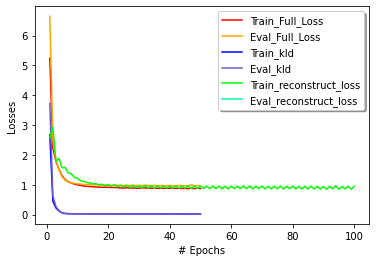

In [22]:
%matplotlib inline
print(len(train_loss[0]))

# Plot losses
plt.plot([i + 1 for i in range(len(train_loss[0]))], train_loss[0], color="red", label="Train_Full_Loss")
plt.plot([i + 1 for i in range(len(eval_loss[0]))], eval_loss[0], color="orange",label="Eval_Full_Loss")
plt.plot([i + 1 for i in range(len(train_loss[1]))], train_loss[1], color="blue",label="Train_kld")
plt.plot([i + 1 for i in range(len(eval_loss[1]))], eval_loss[1], color="slateblue",label="Eval_kld")
plt.plot([i + 1 for i in range(len(train_loss[2]))], train_loss[2], color="lime",label="Train_reconstruct_loss")
plt.plot([i + 1 for i in range(len(eval_loss[2]))], eval_loss[2], color="mediumspringgreen",label="Eval_reconstruct_loss")

# Legend

plt.legend(loc='upper right',shadow=True)


# Label
plt.xlabel("# Epochs")
plt.ylabel("Losses")


In [24]:
def visualization(x):
    kx = get_minibatch(x,25,device)
    kx = add_noise(kx, std=1/3., device=device)
    gen = model.generate(kx).cpu().detach().numpy()
    kx = kx.cpu().detach().numpy()
    

    fig, ax = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax[i-1,j-1].axis("off")
            tmp = kx[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax[i - 1,j - 1].imshow(tmp,cmap="gray")
    
    
    
    
    fig2, ax2 = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax2[i-1,j-1].axis("off")
            tmp = gen[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax2[i - 1,j - 1].imshow(tmp,cmap="gray")
    fig.show()
    fig2.show()

/tmp/ipykernel_78290/2716401791.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_78290/2716401791.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


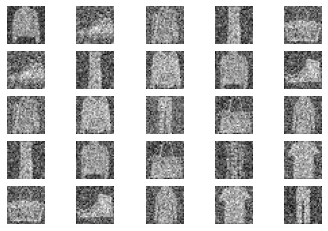

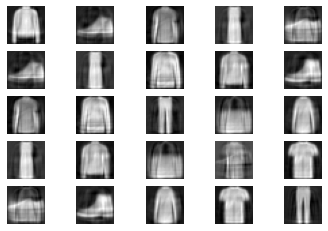

In [25]:
visualization(eval_data)